In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Mute warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('/kaggle/input/medical-insurance-cost-dataset/insurance.csv')

In [3]:
# notebook: House Prices--advance_preprocesor_search_parameters.ipynb
def grab_col_names(df, target=None, cat_th=10, car_th=20):
    # Categóricas (objetos, categorías o booleanas)
    cat_cols = [col for col in df.columns if df[col].dtype in ["O", "category", "bool"]]
    
    # Numéricas pero categóricas (discretas con pocas categorías)
    num_but_cat = [col for col in df.columns 
                   if df[col].nunique() < cat_th and df[col].dtype in ["int64", "float64"]]
    
    # Categóricas cardinales (muchas categorías únicas)
    cat_but_car = [col for col in df.columns 
                   if df[col].nunique() > car_th and df[col].dtype in ["O", "category"]]
    
    # Unir categóricas verdaderas + numéricas discretas
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # Numéricas reales (sin incluir num_but_cat)
    num_cols = [col for col in df.columns if df[col].dtype in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    # Excluir target si está en alguna lista
    if target:
        for col_list in [cat_cols, num_cols, cat_but_car, num_but_cat]:
            if target in col_list:
                col_list.remove(target)
                
    cat_cols = [col for col in cat_cols if col not in num_but_cat]
    
    # Resumen
    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    
    return cat_cols, num_cols, cat_but_car, num_but_cat
#-----------------------------------------------------------------------------------------------
def col_ratio(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
#-----------------------------------------------------------------------------------------------
from sklearn.feature_selection import mutual_info_regression

# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()
#-----------------------------------------------------------------------------------------------
def corr_matrix(df, figsize=(10,8), cmap="coolwarm", factorize_categorical=True):
    df = df.copy()
    
    if factorize_categorical:
        for col in df.select_dtypes(["object", "category"]):
            df[col], _ = df[col].factorize()
    
    corr_matrix = df.corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap=cmap)
    plt.title("Correlation Matrix")
    plt.show()
#-----------------------------------------------------------------------------------------------

In [4]:
# Data visualization
print(20*'****')
print('DIMENSION OF THE DATA IMPORTED: \n')
print('Medical_Insurance_Cost_Dataframe = ',df.shape)
print(20*'****')
print('Medical_Insurance_Cost_Dataframe: \n')
print(df.head(),'\n')
print(20*'****')
print('Medical_Insurance_Cost_Dataframe COLUMNS: \n\nCOLUMN  |||  DTYPE  |||  UNIQUE VALUES\n')
for i in df.columns:
    print(f'"{i}"  |||  dtype:{df[i].dtypes}  |||  unique_values:{df[i].nunique()}\n')
print(20*'****')
print('Medical_Insurance_Cost_Dataframe DESCRIBE:')
print(df.describe())
print(20*'****')

********************************************************************************
DIMENSION OF THE DATA IMPORTED: 

Medical_Insurance_Cost_Dataframe =  (1338, 7)
********************************************************************************
Medical_Insurance_Cost_Dataframe: 

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520 

********************************************************************************
Medical_Insurance_Cost_Dataframe COLUMNS: 

COLUMN  |||  DTYPE  |||  UNIQUE VALUES

"age"  |||  dtype:int64  |||  unique_values:47

"sex"  |||  dtype:object  |||  unique_values:2

"bmi"  |||  dtype:float64  |||  unique_values:548

"children"  |||  dtype:i

# Definition of the columns and their types

In [5]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 3
num_cols: 3
cat_but_car: 0
num_but_cat: 1


# Data cleanning
## ***This dataset dont have null values***

In [6]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# EDA

## Histograms for numeric columns

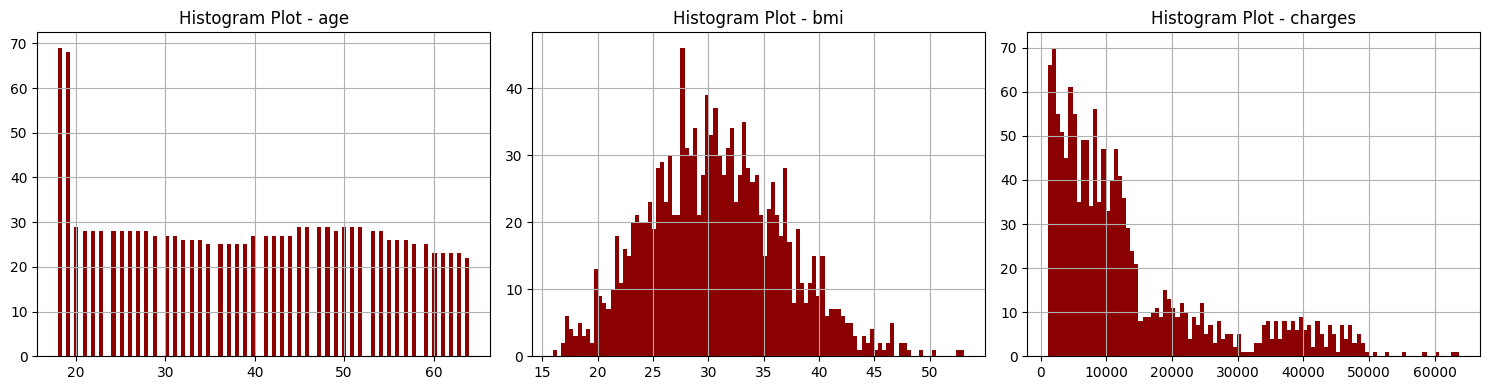

In [7]:
n_cols=3
n_rows=len(num_cols)//n_cols
if len(num_cols) % n_cols != 0:
    n_rows+=1
    
fig,axes=plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes=axes.flatten()

for i, col in enumerate(num_cols):
    df[col].hist(bins=100, color='darkred', ax=axes[i])
    axes[i].set_title(f'Histogram Plot - {col}')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Bar Plot for categorical columns

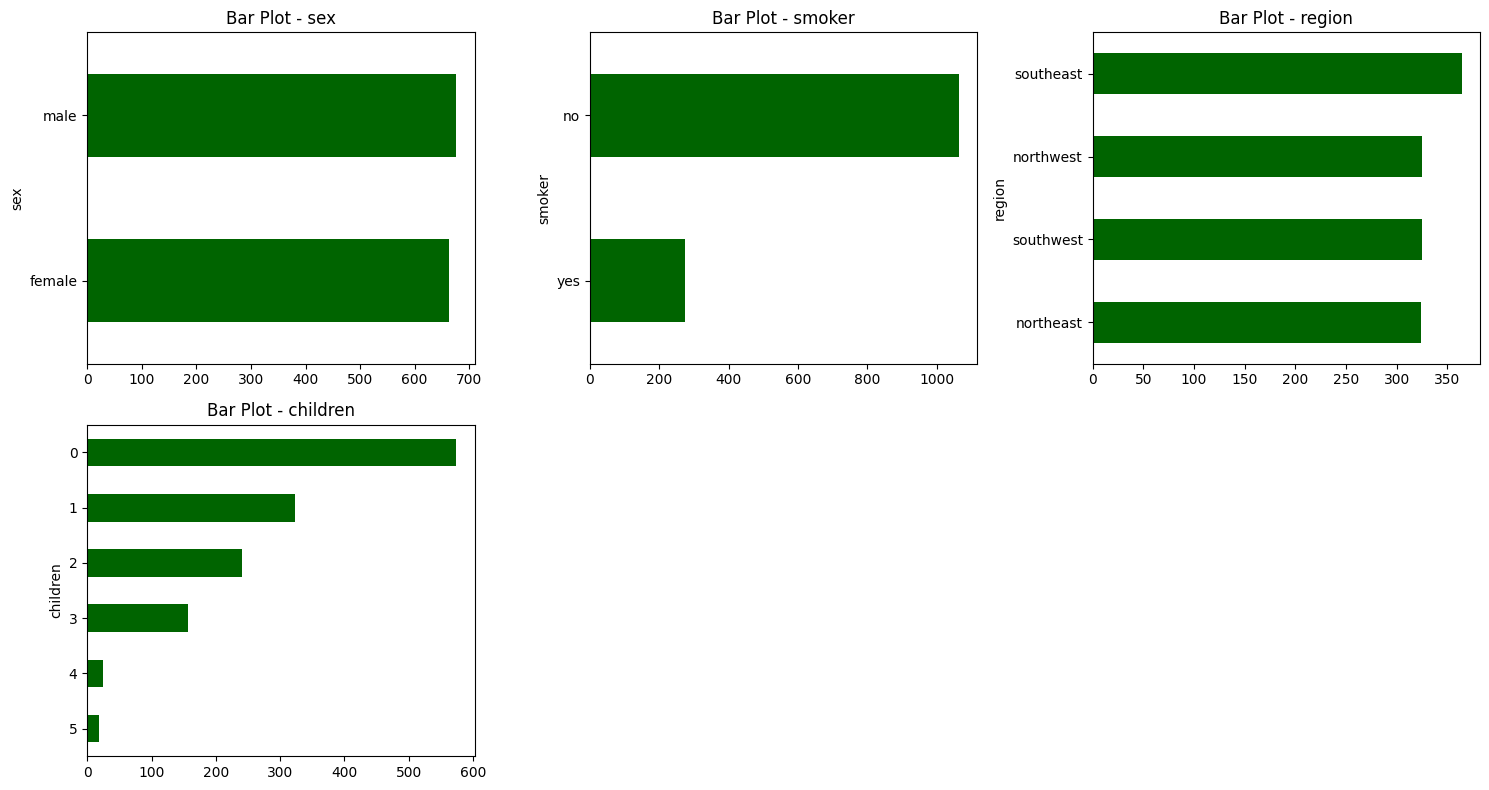

In [8]:
cols_to_plot = cat_cols+num_but_cat

n_cols=3
n_rows=len(cols_to_plot)//n_cols
if len(cols_to_plot) % n_cols != 0:
    n_rows+=1
    
fig,axes=plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes=axes.flatten()

for i, col in enumerate(cols_to_plot):
    df[col].value_counts().sort_values().plot.barh(
        ax=axes[i],
        color='darkgreen'
    )
    axes[i].set_title(f'Bar Plot - {col}')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Scatterplot for view the distribution of Charges vs BMI

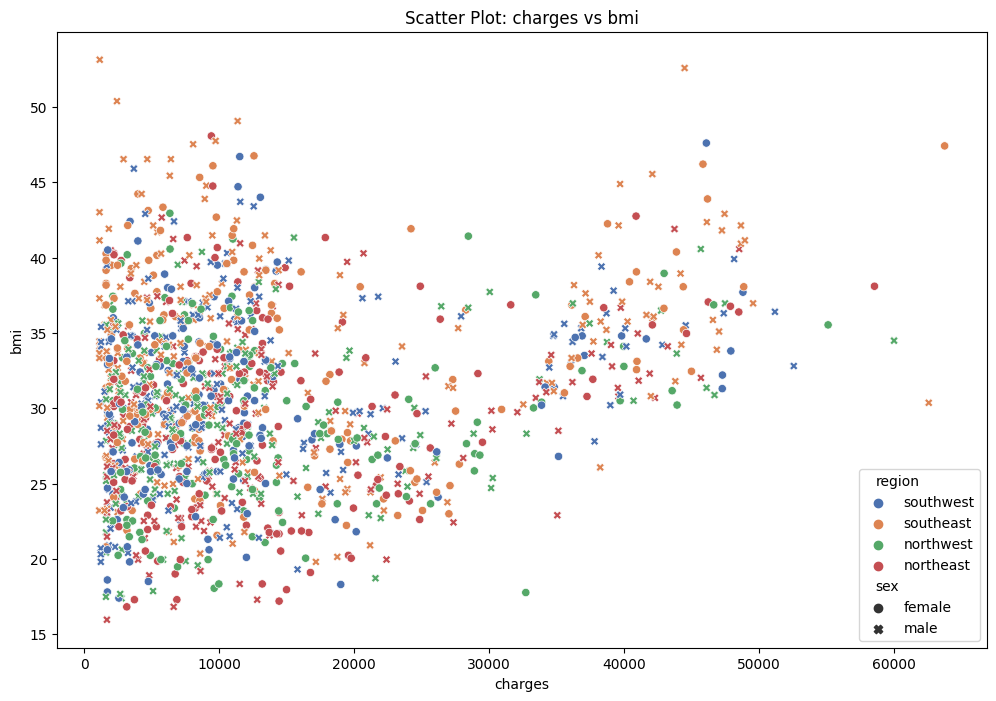

In [9]:
plt.figure(figsize=(12, 8)) 
sns.scatterplot(
    data=df,
    x="charges",   
    y="bmi",        
    hue="region",       
    style="sex",        
    palette="deep"
)
plt.title('Scatter Plot: charges vs bmi')
plt.show()

# Split of X and y

In [10]:
X = df.drop(columns=['charges'],axis=1)
y = df.charges

# Mi Scores

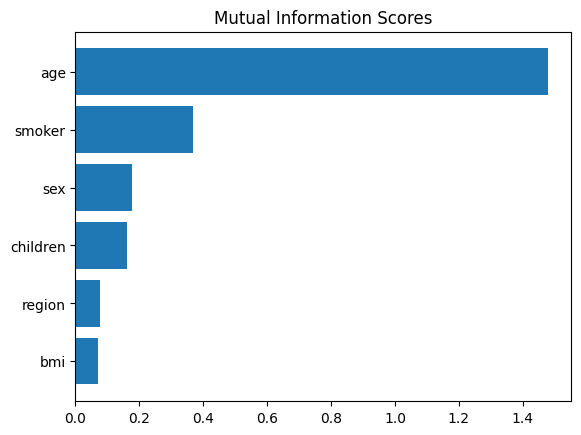

In [11]:
scores = make_mi_scores(X, y)
plot_mi_scores(scores)

# Correlation matrix

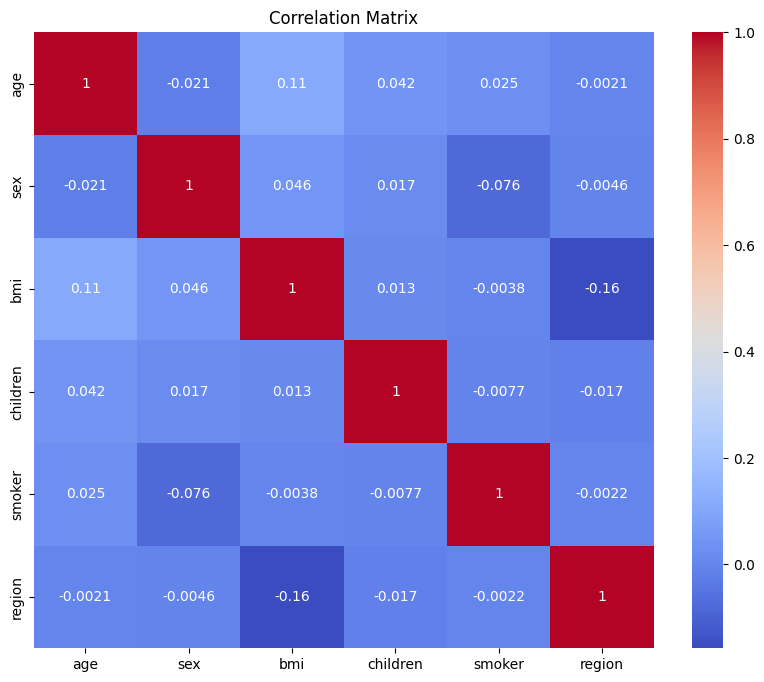

In [12]:
corr_matrix(X)

# Train model

In [13]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(X)

print('Cat_cols:\n',cat_cols)
print('num_cols:\n',num_cols)
print('cat_but_car:\n',cat_but_car)
print('num_but_cat:\n',num_but_cat)

Observations: 1338
Variables: 6
cat_cols: 3
num_cols: 2
cat_but_car: 0
num_but_cat: 1
Cat_cols:
 ['sex', 'smoker', 'region']
num_cols:
 ['age', 'bmi']
cat_but_car:
 []
num_but_cat:
 ['children']


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

one_hot_cols = cat_cols
passthrough_cols = num_but_cat 

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), one_hot_cols),
        ("scaler", StandardScaler(), num_cols),
        ("passthrough", "passthrough", passthrough_cols)
    ]
)

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=0),
    "SVR": SVR(kernel="rbf"),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=0)
}

resultados = []

for nombre, modelo in modelos.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", modelo)
    ])
 
    pipe.fit(X_train, y_train)  
    y_pred = pipe.predict(X_valid) 
    
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    r2 = r2_score(y_valid, y_pred)
    
    resultados.append((nombre, mae, rmse, r2))


resultados = sorted(resultados, key=lambda x: x[3], reverse=True)

for nombre, mae, rmse, r2 in resultados:
    print(f"{nombre:20} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e+10, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(


Gradient Boosting    | MAE: 2398.29 | RMSE: 4323.45 | R²: 0.880
Random Forest        | MAE: 2520.67 | RMSE: 4643.89 | R²: 0.861
XGBoost              | MAE: 2559.24 | RMSE: 4704.90 | R²: 0.857
Linear Regression    | MAE: 4084.16 | RMSE: 5792.12 | R²: 0.784
Lasso                | MAE: 4181.19 | RMSE: 5796.28 | R²: 0.784
ElasticNet           | MAE: 4184.22 | RMSE: 5797.34 | R²: 0.784
Ridge                | MAE: 4186.91 | RMSE: 5798.29 | R²: 0.783
Decision Tree        | MAE: 3282.19 | RMSE: 6924.09 | R²: 0.691
SVR                  | MAE: 8607.40 | RMSE: 12892.24 | R²: -0.071


# Model Stacking

In [16]:
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor

estimators = [
    ("gbr", GradientBoostingRegressor(random_state=0)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=0)),
    ("xgb", XGBRegressor(
        n_estimators=200, 
        learning_rate=0.1, 
        random_state=0,
        enable_categorical=False 
    ))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    passthrough=True,
    n_jobs=-1
)

stacking_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", stacking_model)
])

stacking_pipeline.fit(X_train, y_train)

y_pred = stacking_pipeline.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
r2 = r2_score(y_valid, y_pred)

print(f"Stacking Pipeline | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

Stacking Pipeline | MAE: 2397.54 | RMSE: 4325.73 | R²: 0.879


# Feature engineering

In [17]:
df['age_group']=pd.cut(
    df['age'],
    bins=[18,30,45,60,100],
    labels=['joven','adulto','maduro','senior']
)
df['bmi_group']=pd.cut(
    df['bmi'],
    bins=[0,18.5,24.9,29.9,np.inf],
    labels=['bajo_peso', 'normal', 'sobrepeso','obeso']
)
df['bmi_squared']=df['bmi']**2
df['has_children']=(df['children']>0).astype(int)
df["smoker_binary"] = df["smoker"].map({"yes": 1, "no": 0})
df["age_bmi"] = df["age"] * df["bmi"]
df["smoker_bmi"] = df["smoker_binary"] * df["bmi"]
df["children_smoker"] = df["children"] * df["smoker_binary"]

df["charges_log"] = np.log1p(df["charges"])

df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'age_group', 'bmi_group', 'bmi_squared', 'has_children',
       'smoker_binary', 'age_bmi', 'smoker_bmi', 'children_smoker',
       'charges_log'],
      dtype='object')

In [18]:
X = df.drop(columns=['charges','charges_log'],axis=1)
y = df.charges_log

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(X)

print('Cat_cols:\n',cat_cols)
print('num_cols:\n',num_cols)
print('cat_but_car:\n',cat_but_car)
print('num_but_cat:\n',num_but_cat)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Observations: 1338
Variables: 14
cat_cols: 5
num_cols: 5
cat_but_car: 0
num_but_cat: 4
Cat_cols:
 ['sex', 'smoker', 'region', 'age_group', 'bmi_group']
num_cols:
 ['age', 'bmi', 'bmi_squared', 'age_bmi', 'smoker_bmi']
cat_but_car:
 []
num_but_cat:
 ['children', 'has_children', 'smoker_binary', 'children_smoker']


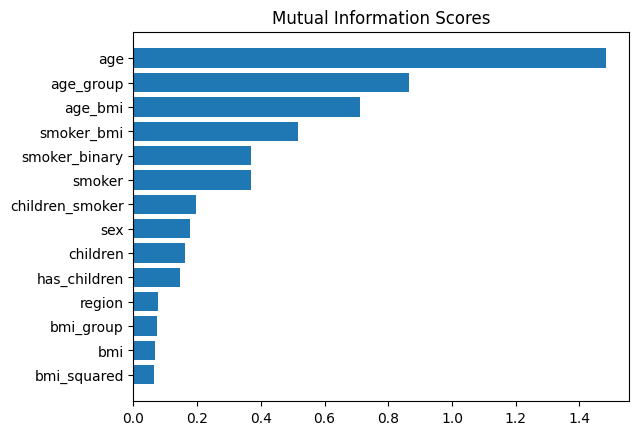

In [19]:
scores = make_mi_scores(X, y)
plot_mi_scores(scores)

In [20]:
one_hot_cols = cat_cols
passthrough_cols = num_but_cat 

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), one_hot_cols),
        ("scaler", StandardScaler(), num_cols),
        ("passthrough", "passthrough", passthrough_cols)
    ]
)

In [21]:
resultados = []

for nombre, modelo in modelos.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", modelo)
    ])
 
    pipe.fit(X_train, y_train)  
    y_pred = pipe.predict(X_valid) 
    
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    r2 = r2_score(y_valid, y_pred)
    
    resultados.append((nombre, mae, rmse, r2))


resultados = sorted(resultados, key=lambda x: x[3], reverse=True)

for nombre, mae, rmse, r2 in resultados:
    print(f"{nombre:20} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

Gradient Boosting    | MAE: 0.19 | RMSE: 0.35 | R²: 0.866
SVR                  | MAE: 0.16 | RMSE: 0.35 | R²: 0.865
Random Forest        | MAE: 0.19 | RMSE: 0.37 | R²: 0.845
XGBoost              | MAE: 0.20 | RMSE: 0.40 | R²: 0.822
Ridge                | MAE: 0.27 | RMSE: 0.40 | R²: 0.819
ElasticNet           | MAE: 0.27 | RMSE: 0.40 | R²: 0.819
Lasso                | MAE: 0.27 | RMSE: 0.40 | R²: 0.818
Linear Regression    | MAE: 0.27 | RMSE: 0.40 | R²: 0.818
Decision Tree        | MAE: 0.24 | RMSE: 0.54 | R²: 0.671


# Model stacking with new features

In [22]:
estimators = [
    ("gbr", GradientBoostingRegressor(random_state=0)),
    ("SVR", SVR(kernel="rbf")),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=0)),
    ("xgb", XGBRegressor(
        n_estimators=200, 
        learning_rate=0.1, 
        random_state=0,
        enable_categorical=False 
    ))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    passthrough=True,
    n_jobs=-1
)

stacking_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", stacking_model)
])

stacking_pipeline.fit(X_train, y_train)

y_pred = stacking_pipeline.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
r2 = r2_score(y_valid, y_pred)

print(f"Stacking Pipeline | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

Stacking Pipeline | MAE: 0.19 | RMSE: 0.35 | R²: 0.867


# Second version of model stacking with the new features

In [23]:
estimators = [
    ("gbr", GradientBoostingRegressor(random_state=0)),
    ("svr", SVR(kernel="rbf"))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    passthrough=True,         
    n_jobs=-1,
    cv=5                     
)

stacking_pipeline = Pipeline([
    ("preprocessor", preprocessor), 
    ("model", stacking_model)
])

stacking_pipeline.fit(X_train, y_train)

y_pred = stacking_pipeline.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
r2 = r2_score(y_valid, y_pred)

print(f"Stacking (SVR + GBR → Ridge) | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

Stacking (SVR + GBR → Ridge) | MAE: 0.19 | RMSE: 0.35 | R²: 0.867


# Transforming back the logaritmic predictions

In [24]:
print('y_pred before log transformation',y_pred[:5])
y_pred = np.expm1(y_pred)
print('y_pred after log transformation',y_pred[:5])

y_pred before log transformation [ 9.22063868  8.64910444 10.27372761  9.18846017 10.30728287]
y_pred after log transformation [10102.51520228  5704.03521871 28960.64396739  9782.57438106
 29948.94795729]
